In [2]:

import librosa
import numpy as np
from scipy.spatial.distance import cdist
from math import inf
from typing import List, Tuple
import fnmatch
import os
from pathlib import Path

NUM_FEATURES: int = 36
hop_samples: int = 2048
window_samples: int = 4096
NUM_QUERIES_IN_REFERENCE: int = 10
LIBROSA_SEMITONE_STEP: float = 0.3
LIBROSA_TIME_STRETCH: float = 1.1
MATCH_THRESHOLD: float = 0.5  # in secs
PITCH_SHIFT: int = 1
TIME_STRETCH: int = 1
DO_MFCC_FEATURE: int = 1
query_directory: str = (
    r"data/sishyaapp_recordings_wav"
)

In [3]:
#The directory holds segmented sishya app files. The files will be
#concatenated to form the reference.
query_file_count: int = len(fnmatch.filter(os.listdir(query_directory), "*.wav"))
num_references: int = int(
    (query_file_count + NUM_QUERIES_IN_REFERENCE - 1) / NUM_QUERIES_IN_REFERENCE
)
print("Query file Count: %d num_references %d" % (query_file_count, num_references))

Query file Count: 76 num_references 8


In [4]:


def do_feature_extraction(y_data: np.ndarray, sr: int) -> np.ndarray:

    if DO_MFCC_FEATURE:
        return librosa.feature.mfcc(
            y=y_data,
            sr=sr,
            n_mfcc=NUM_FEATURES,
            n_fft=window_samples,
            hop_length=hop_samples,
            center=False,
        )

    return librosa.feature.chroma_stft(
        y=y_data,
        sr=sr,
        n_chroma=NUM_FEATURES,
        n_fft=window_samples,
        hop_length=hop_samples,
        center=False,
    )


In [5]:

def modify_query_librosa(y_query: np.ndarray, sr: int) -> np.ndarray:
    if PITCH_SHIFT:
        y_query = librosa.effects.pitch_shift(
            y=y_query, sr=sr, n_steps=LIBROSA_SEMITONE_STEP
        )
    if TIME_STRETCH:
        y_query = librosa.effects.time_stretch(y=y_query, rate=LIBROSA_TIME_STRETCH)
    return y_query


In [6]:

def get_next_distance(
    reference_idx: int, query_idx: int, distances: np.ndarray
) -> Tuple[float, int, int]:
    distance: float = 0

    # Reached the end of the query
    if query_idx == distances.shape[1] - 1:
        distance = -1
    else:
        # at the end of the reference, align all the coming queries to this end
        if reference_idx == distances.shape[0] - 1:
            query_idx = query_idx + 1
            assert query_idx < distances.shape[1]
            distance = distances[reference_idx][query_idx]
        else:
            temp_distance: List[float] = []
            min_dist: float = inf
            min_idx: int = -1

            # match
            temp_distance.append(distances[reference_idx + 1][query_idx + 1])
            # insert
            temp_distance.append(distances[reference_idx][query_idx + 1])
            # delete
            temp_distance.append(distances[reference_idx + 1][query_idx])

            for k in range(0, len(temp_distance)):
                if temp_distance[k] < min_dist:
                    min_dist = temp_distance[k]
                    min_idx = k

            if min_idx == 0:
                reference_idx, query_idx = reference_idx + 1, query_idx + 1
            elif min_idx == 1:
                reference_idx, query_idx = reference_idx, query_idx + 1
            else:
                assert min_idx == 2
                reference_idx, query_idx = reference_idx + 1, query_idx

            distance = min_dist

    return distance, reference_idx, query_idx


"""
calculate_min_distance

parameters:
1. reference_idx : the current start of the reference. 
runs from 0 to the number of elements in the reference - 1
2. distances : the distance matrix
3. min_distance : the minimum distance till now. 

functionality:

The reference_idx is aligned with the start of the query.
Then the dtw algorithm is used to find the next alignments.
The current query element could be aligned with the next reference (insert)
The current reference could be aligned with the next query (delete)
The next reference and next query could be aligned with each other (match)

If the current match iteration exceeds the current minimum distance, the
function quits. Since the purpose is to find the match with the minimum
distance, no point in doing further alignment when the distance is not
going to be the best one.

returns:
1. total_distance : the distance for aligning query with the reference
begining at the reference_idx.
2. reference_end_idx : the end of alignment of the query 
within the reference

"""

def calculate_min_distance(
    reference_idx: int, distances: np.ndarray, min_distance: float
) -> Tuple[float, int]:
    total_distance: float = 0
    query_idx: int = 0

    next_distance: float = distances[reference_idx][0]

    while next_distance >= 0:

        total_distance = total_distance + next_distance
        next_distance, reference_idx, query_idx = get_next_distance(
            reference_idx, query_idx, distances
        )

        # no need to traverse any more, this is not the best match
        if total_distance > min_distance:
            break

    return total_distance, reference_idx


"""
least_distance_mfcc

parameters:
1. mfcc_reference : the reference mfcc array
2. mfcc_query : the query mfcc array

functionality:
with every element in the reference as the start the function
calculates the distance of aligning the query with the reference
begining at the current element. for eg. the function first finds the
distance of algning the query with the reference begining at element 0.
if the query is of length 10, it could be alinged with elements 0-8 of
the reference with a total distance of 4.5. Then in the next iteration
with the start of the reference being the first element, the 10 element 
query could be aligned with 1-11 with a total distance of 6.7. Then with
2-10, 3-11 etc. with the respective distances. The best match is the one
with the least distance.

returns:
1. the start of the best match
2. end of the best match
"""


def least_distance_mfcc(
    mfcc_reference: np.ndarray, mfcc_query: np.ndarray
) -> Tuple[int, int]:
    min_distance: float = inf
    start_index: int = 0
    end_index: int = 0

    distances: np.ndarray = cdist(mfcc_reference.T, mfcc_query.T, "euclidean")

    for i in range(0, distances.shape[0]):
        current_distance, end = calculate_min_distance(i, distances, min_distance)
        if current_distance < min_distance:
            min_distance = current_distance
            start_index = i
            end_index = end

    return start_index, end_index

In [112]:
queries_left: int = query_file_count
query_file_number: int = 0
mismatches: int = 0

early_exit = False

for i in range(0, num_references):

    current_number_of_queries_in_reference = min(NUM_QUERIES_IN_REFERENCE, queries_left)

    y_reference = []
    y_query_array = []

    for j in range(0, current_number_of_queries_in_reference):

        f = r"%s/vs-%d.wav" % (query_directory, query_file_number)
        query_file_number = query_file_number + 1

        y_query, sr = librosa.load(f, sr = None)
        y_reference = np.concatenate((y_reference, y_query))
        y_query_array.append(y_query)

    assert len(y_reference) == sum(len(x) for x in y_query_array)

    mfcc_reference = do_feature_extraction(y_reference, sr)

    current_query_start, current_query_end = 0, 0

    for j in range(0, current_number_of_queries_in_reference):

        if j != 0:
            current_query_start = current_query_end + 1

        current_query_end = current_query_start + len(y_query_array[j]) - 1

        modified_query = modify_query_librosa(y_query_array[j], sr)

        mfcc_query = do_feature_extraction(modified_query, sr)

        D, wp = librosa.sequence.dtw(mfcc_query, mfcc_reference, subseq=True)
        # start_index, end_index = least_distance_mfcc(mfcc_reference, mfcc_query)
        start_index = wp[-1][1]
        end_index = wp[0][1]

        
        print(
            "i %d j %d. Expected start %d end %d. Returned start %d end sec %d"
            % (
                i,
                j,
                current_query_start ,
                current_query_end ,
                (start_index * hop_samples) ,
                (end_index * hop_samples),
            )
        )

        if (
            abs((current_query_start / sr) - ((start_index * hop_samples) / sr))
            > MATCH_THRESHOLD
            and abs((current_query_end / sr) - ((end_index * hop_samples) / sr))
            > MATCH_THRESHOLD
        ):
            print("*** MISMATCH ***")
            mismatches += 1
        
    assert current_query_end == len(y_reference) - 1

    queries_left = queries_left - current_number_of_queries_in_reference

assert queries_left == 0
assert query_file_number == query_file_count

print("DONE!. Mismatches: ", mismatches)

i 0 j 0. Expected start 0 end 20247. Returned start 104448 end sec 104448
*** MISMATCH ***
i 0 j 1. Expected start 20248 end 41289. Returned start 167936 end sec 172032
*** MISMATCH ***
i 0 j 2. Expected start 41290 end 61083. Returned start 40960 end sec 45056
i 0 j 3. Expected start 61084 end 85528. Returned start 145408 end sec 149504
*** MISMATCH ***
i 0 j 4. Expected start 85529 end 107761. Returned start 86016 end sec 100352
i 0 j 5. Expected start 107762 end 134191. Returned start 108544 end sec 129024
i 0 j 6. Expected start 134192 end 154611. Returned start 135168 end sec 149504
i 0 j 7. Expected start 154612 end 176042. Returned start 155648 end sec 169984
i 0 j 8. Expected start 176043 end 197305. Returned start 176128 end sec 190464
i 0 j 9. Expected start 197306 end 220945. Returned start 10240 end sec 14336
*** MISMATCH ***
i 1 j 0. Expected start 0 end 20483. Returned start 0 end sec 8192
i 1 j 1. Expected start 20484 end 44733. Returned start 20480 end sec 30720
i 1 j 2

In [66]:
y_reference.shape

(608988,)

In [92]:
j = 5
modified_query = modify_query_librosa(y_query_array[j], sr)

In [93]:
from IPython.display import Audio
Audio(data=y_reference, rate=sr)

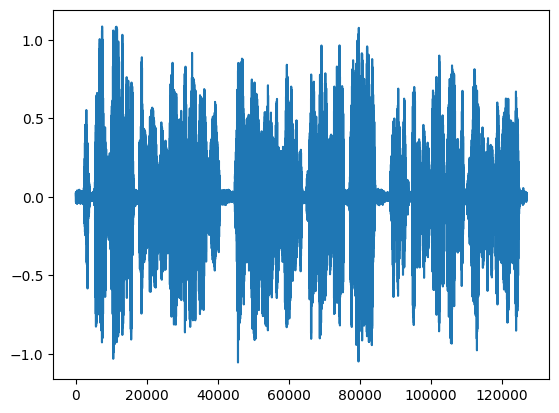

In [94]:
plt.plot(y_reference)

In [109]:
Audio(data=modified_query, rate=sr)


In [111]:
Audio(data=y_reference[104448:122880], rate=sr)


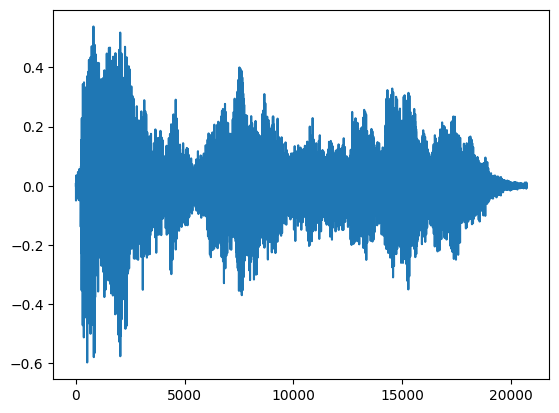

In [97]:
plt.plot(modified_query)

In [98]:
mfcc_query = do_feature_extraction(modified_query, sr)
mfcc_reference = do_feature_extraction(y_reference, sr)

In [99]:
mfcc_query.shape, mfcc_reference.shape

((36, 9), (36, 61))

In [101]:
D, wp = librosa.sequence.dtw(mfcc_query, mfcc_reference, subseq=True)

In [102]:
wp

array([[ 8, 60],
       [ 7, 59],
       [ 6, 58],
       [ 5, 57],
       [ 4, 56],
       [ 4, 55],
       [ 3, 54],
       [ 2, 53],
       [ 1, 52],
       [ 0, 51]])

In [103]:
import matplotlib.pyplot as plt

In [18]:
plt.ion()

[(0.0, 61.0), (0.0, 500.0)]

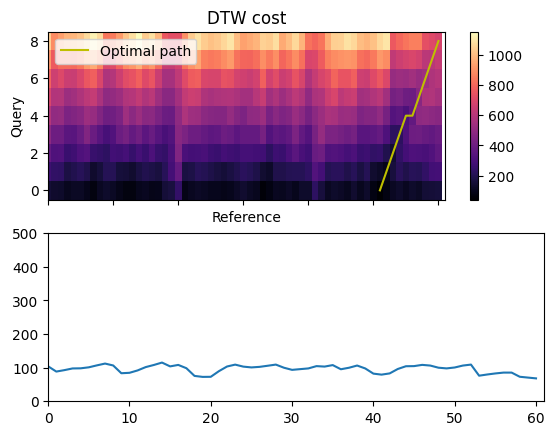

In [104]:
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(D, x_axis='frames', y_axis='frames',
                               ax=ax[0])
ax[0].set(title='DTW cost', xlabel='Reference', ylabel='Query')
ax[0].plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')
ax[0].legend()
fig.colorbar(img, ax=ax[0])
ax[1].plot(D[-1, :] / wp.shape[0])
ax[1].set(xlim=[0, mfcc_reference.shape[1]], ylim=[0, 500])


In [106]:
Audio(data=modified_query, rate=sr)
Audio(data=y_reference[51*2048:61*2048], rate=sr)


In [107]:
distances = cdist(mfcc_query.T, mfcc_reference.T)

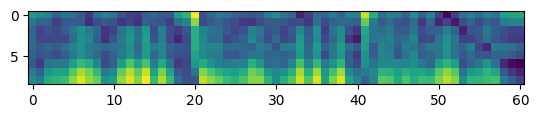

In [108]:
plt.imshow(distances)

In [53]:
D, wp = librosa.sequence.dtw(C=distances)

In [55]:
D, wp = librosa.sequence.dtw(mfcc_query, mfcc_reference, subseq=True)

In [56]:
wp

array([[22,  6],
       [21,  6],
       [20,  6],
       [19,  6],
       [18,  6],
       [17,  6],
       [16,  6],
       [15,  6],
       [14,  6],
       [13,  6],
       [12,  6],
       [11,  6],
       [10,  6],
       [ 9,  6],
       [ 8,  6],
       [ 7,  6],
       [ 6,  6],
       [ 5,  6],
       [ 4,  6],
       [ 3,  6],
       [ 2,  6],
       [ 1,  5],
       [ 0,  5]])

[(0.0, 170.0), (0.0, 500.0)]

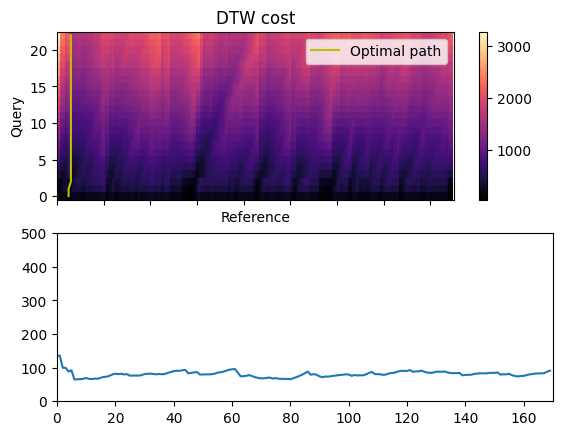

In [60]:
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(D, x_axis='frames', y_axis='frames',
                               ax=ax[0])
ax[0].set(title='DTW cost', xlabel='Reference', ylabel='Query')
ax[0].plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')
ax[0].legend()
fig.colorbar(img, ax=ax[0])
ax[1].plot(D[-2, :] / wp.shape[0])
ax[1].set(xlim=[0, mfcc_reference.shape[1]], ylim=[0, 500])


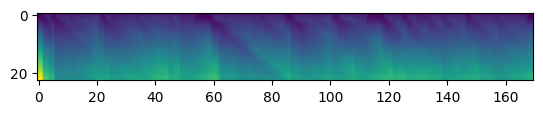

In [64]:
plt.imshow(D)

In [47]:
D, wp = librosa.sequence.dtw(mfcc_reference, mfcc_query, subseq=True)

In [48]:
wp

array([[55, 21],
       [54, 20],
       [54, 19],
       [54, 18],
       [54, 17],
       [54, 16],
       [53, 15],
       [52, 14],
       [51, 13],
       [50, 12],
       [49, 11],
       [48, 10],
       [47,  9],
       [46,  8],
       [45,  7],
       [45,  6],
       [45,  5],
       [45,  4],
       [45,  3],
       [45,  2],
       [45,  1],
       [45,  0]])